In [2]:
import heapq
from typing import Dict, Union, Tuple, List

In [3]:
import folium
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from geopy.distance import geodesic

In [4]:
class Graph:
    def __init__(self) -> None:
        self.adjacency_list: Dict[int, Dict[int, float]] = {}
        self.city_to_id: Dict[str, int] = {}
        self.id_to_city: Dict[int, str] = {}
        self.next_id = 0
    def add_city(self, city_name: str) -> int:
        if city_name not in self.city_to_id:
            self.city_to_id[city_name] = self.next_id
            self.id_to_city[self.next_id] = city_name
            self.adjacency_list[self.next_id] = {}
            self.next_id += 1
        return self.city_to_id[city_name]
    def add_edge(self, city_a: str, city_b: str, weight: float) -> None:
        a_id = self.add_city(city_a)
        b_id = self.add_city(city_b)
        self.adjacency_list[a_id][b_id] = weight
        self.adjacency_list[b_id][a_id] = weight

In [5]:
def build_full_polish_graph(polish_df: pd.DataFrame) -> Graph:
    g = Graph()
    city_names = polish_df["city"].tolist()
    for i in range(len(city_names)):
        for j in range(i + 1, len(city_names)):
            city_a = city_names[i]
            city_b = city_names[j]
            row_a = polish_df[polish_df["city"] == city_a].iloc[0]
            row_b = polish_df[polish_df["city"] == city_b].iloc[0]
            lat_a, lng_a = row_a["lat"], row_a["lng"]
            lat_b, lng_b = row_b["lat"], row_b["lng"]
            dist_km = geodesic((lat_a, lng_a), (lat_b, lng_b)).km
            g.add_edge(city_a, city_b, dist_km)
    return g

In [6]:
def dijkstra(graph: Graph, source_city: str) -> Tuple[Dict[int, float], Dict[int, Union[int, None]]]:
    if source_city not in graph.city_to_id:
        raise ValueError(f"Source city '{source_city}' not found in graph.")
    source_id = graph.city_to_id[source_city]
    distances = {node_id: float("inf") for node_id in graph.adjacency_list.keys()}
    predecessors = {node_id: None for node_id in graph.adjacency_list.keys()}
    distances[source_id] = 0.0
    pq = [(0.0, source_id)]
    while pq:
        current_dist, current_vertex = heapq.heappop(pq)
        if current_dist > distances[current_vertex]:
            continue
        for neighbor, weight in graph.adjacency_list[current_vertex].items():
            alt = current_dist + weight
            if alt < distances[neighbor]:
                distances[neighbor] = alt
                predecessors[neighbor] = current_vertex
                heapq.heappush(pq, (alt, neighbor))
    return distances, predecessors

In [7]:
def reconstruct_path(
        graph: Graph, source_city: str, target_city: str,
        predecessors: Dict[int, Union[int, None]]
) -> List[str]:
    if target_city not in graph.city_to_id:
        raise ValueError(f"Target city '{target_city}' not found in graph.")
    source_id = graph.city_to_id[source_city]
    target_id = graph.city_to_id[target_city]
    path_ids = []
    current = target_id
    while current is not None:
        path_ids.append(current)
        current = predecessors[current]
    path_ids.reverse()
    if not path_ids or path_ids[0] != source_id:
        raise ValueError(f"No path from '{source_city}' to '{target_city}' found.")
    return [graph.id_to_city[node_id] for node_id in path_ids]

In [8]:
def visualize_full_graph_with_path(
        g: Graph, polish_df: pd.DataFrame, path_cities: List[str],
        title: str = "", figsize=(12, 10)
) -> None:
    G_nx = nx.Graph()
    for _, row in polish_df.iterrows():
        city = row["city"]
        lat = row["lat"]
        lng = row["lng"]
        G_nx.add_node(city, pos=(lng, lat))
    for city_a, a_id in g.city_to_id.items():
        for b_id, w in g.adjacency_list[a_id].items():
            city_b = g.id_to_city[b_id]
            if not G_nx.has_edge(city_a, city_b):
                G_nx.add_edge(city_a, city_b, weight=w)
    pos = nx.get_node_attributes(G_nx, 'pos')
    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(G_nx, pos, node_color="lightblue", edgecolors="black", node_size=100)
    nx.draw_networkx_edges(G_nx, pos, edge_color="gray", width=0.3)
    nx.draw_networkx_labels(G_nx, pos, font_size=5)
    if len(path_cities) > 1:
        path_edges = list(zip(path_cities, path_cities[1:]))
        nx.draw_networkx_edges(G_nx, pos, edgelist=path_edges, edge_color="red", width=2)
        nx.draw_networkx_nodes(G_nx, pos, nodelist=path_cities, node_color="orange", node_size=150)
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

In [9]:
def visualize_subgraph_with_path(
        g: Graph, polish_df: pd.DataFrame, path_cities: List[str],
        title: str = "", figsize=(8, 6)
) -> None:
    subG_nx = nx.Graph()
    for city in path_cities:
        row = polish_df[polish_df["city"] == city].iloc[0]
        lat, lng = row["lat"], row["lng"]
        subG_nx.add_node(city, pos=(lng, lat))
    for i in range(len(path_cities) - 1):
        city_a = path_cities[i]
        city_b = path_cities[i + 1]
        a_id = g.city_to_id[city_a]
        b_id = g.city_to_id[city_b]
        weight = g.adjacency_list[a_id][b_id]
        subG_nx.add_edge(city_a, city_b, weight=weight)
    pos = nx.get_node_attributes(subG_nx, 'pos')
    plt.figure(figsize=figsize)
    nx.draw(subG_nx, pos, with_labels=False, node_color="orange", edge_color="red",
            width=2, node_size=300, font_size=10)
    for i, city in enumerate(path_cities):
        x, y = pos[city]
        plt.text(x, y, str(i + 1), fontsize=8, color="blue", ha="center", va="center")
        plt.text(x + 0.02, y + 0.02, city, fontsize=8, color="black", ha="left")
    edge_labels = nx.get_edge_attributes(subG_nx, 'weight')
    edge_labels = {edge: f"{weight:.2f} km" for edge, weight in edge_labels.items()}
    nx.draw_networkx_edge_labels(subG_nx, pos, edge_labels=edge_labels, font_size=8, label_pos=0.5)
    plt.title(title, fontsize=12)
    plt.axis("off")
    plt.show()

In [10]:
def visualize_path_on_folium(
        polish_df: pd.DataFrame, path_cities: List[str],
        out_html: str = "path.html"
) -> None:
    if len(path_cities) == 0:
        print("No path cities to visualize.")
        return
    if len(path_cities) == 1:
        single_city = path_cities[0]
        row = polish_df[polish_df["city"] == single_city].iloc[0]
        folium.Map(location=[row["lat"], row["lng"]], zoom_start=6).save(out_html)
        print(f"Only one city to visualize. Map saved to {out_html}")
        return
    first_city = path_cities[0]
    row_first = polish_df[polish_df["city"] == first_city].iloc[0]
    map_center = [row_first["lat"], row_first["lng"]]
    m = folium.Map(location=map_center, zoom_start=6)
    coords = []
    for city in path_cities:
        row = polish_df[polish_df["city"] == city].iloc[0]
        coords.append((row["lat"], row["lng"]))
    for i, city in enumerate(path_cities):
        lat, lng = coords[i]
        folium.Marker(
            location=[lat, lng],
            popup=f"{city} (stop #{i + 1})",
            icon=folium.Icon(color="orange", icon="info-sign"),
        ).add_to(m)
    folium.PolyLine(coords, color="red", weight=4, opacity=0.8).add_to(m)
    m.save(out_html)
    print(f"Interactive Folium map with path saved to '{out_html}'.")

In [11]:
def load_csv(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    return df

In [12]:
def main():
    file_path = "../../data/worldcities.csv"
    df = load_csv(file_path)
    polish_df = df[df["country"] == "Poland"].copy()
    full_graph = build_full_polish_graph(polish_df)
    cities_to_visit = [
        "Warsaw", "Białystok", "Gdańsk", "Szczecin", "Poznań",
        "Wrocław", "Katowice", "Kraków", "Lublin", "Rzeszów"
    ]
    full_path = []
    total_distance = 0.0
    for i in range(len(cities_to_visit) - 1):
        source_city = cities_to_visit[i]
        target_city = cities_to_visit[i + 1]
        distances, predecessors = dijkstra(full_graph, source_city)
        segment_path = reconstruct_path(full_graph, source_city, target_city, predecessors)
        segment_distance = distances[full_graph.city_to_id[target_city]]
        if i == 0:
            full_path.extend(segment_path)
        else:
            full_path.extend(segment_path[1:])
        total_distance += segment_distance
    print(f"Shortest path visiting {len(cities_to_visit)} cities: {' -> '.join(full_path)}")
    print(f"Total distance: {total_distance:.2f} km")
    visualize_full_graph_with_path(
        full_graph,
        polish_df,
        full_path,
        title="Shortest Path Visiting 10 Polish Cities"
    )
    visualize_subgraph_with_path(
        full_graph,
        polish_df,
        full_path,
        title="Subgraph of Shortest Path (Visited Cities)"
    )
    visualize_path_on_folium(
        polish_df,
        full_path,
        out_html="polish_cities_path.html"
    )

Shortest path visiting 10 cities: Warsaw -> Białystok -> Gdańsk -> Szczecin -> Poznań -> Wrocław -> Katowice -> Kraków -> Lublin -> Rzeszów
Total distance: 1739.13 km


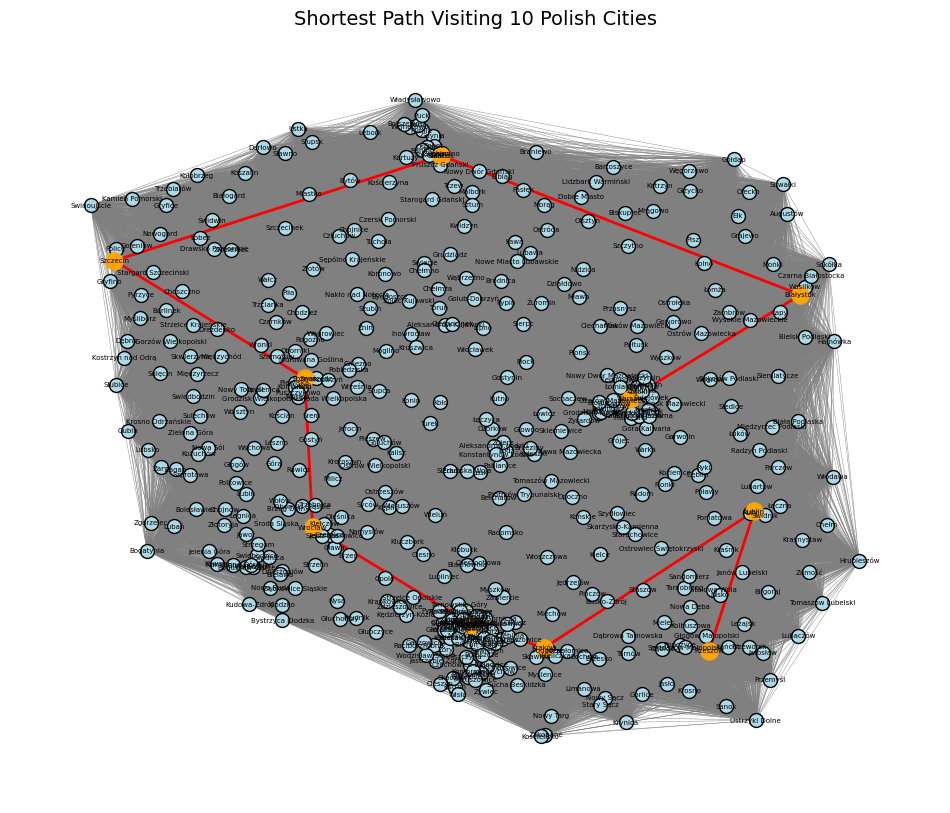

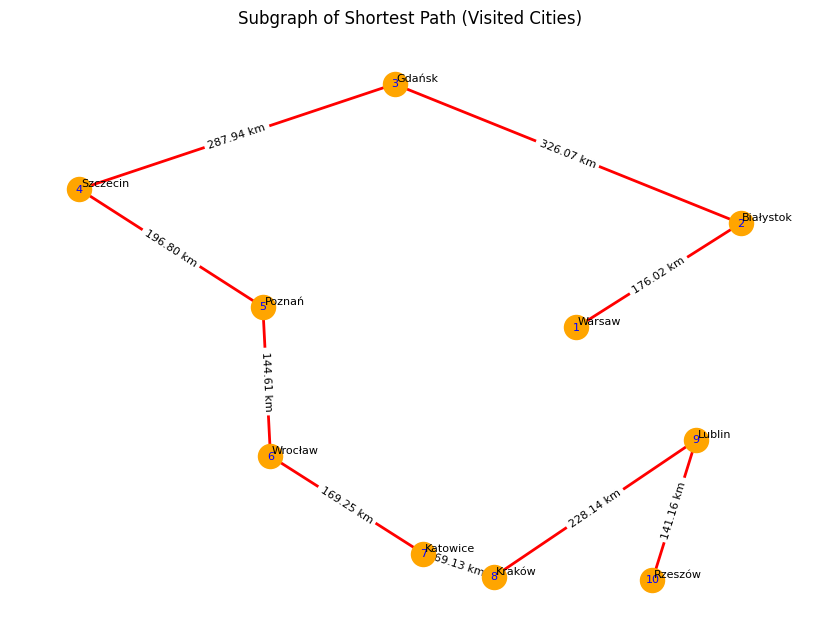

Interactive Folium map with path saved to 'polish_cities_path.html'.


In [13]:
if __name__ == "__main__":
    main()